# Community detection using bounded confidence à la Hansen and Ghrist

In [2]:
#%pylab qt5
#%precision 5
#set_printoptions(precision=5)
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (11, 7)
import networkx as nx
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## The karate club graph G

For now we will investigate the karate club graph to test the community detection

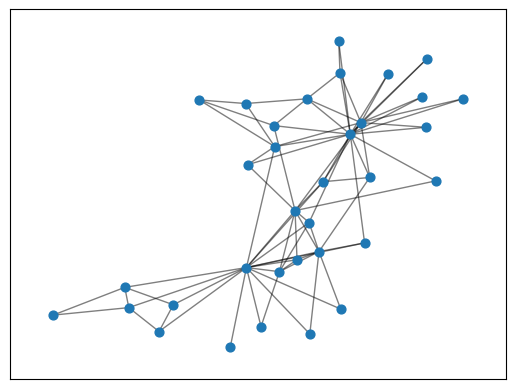

In [37]:
# load the karate club graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

#### Defining some functions

In [6]:
def phi(dist):
    """
    threshold function
    """
    if dist<1:
        res=1-dist
    else:
        res=0
    return res

In [7]:
def abl(t,arr):
    """
    The derivative function for solving the dynamics
    """
    inc=nx.incidence_matrix(G,oriented=True).toarray()
    v=[]
    for k in nx.edges(G):
        v=np.append(v,[phi(abs(arr[k[0]]-arr[k[1]]))])
    return -np.dot(np.matmul(np.matmul(inc,np.diag(v)),np.transpose(inc)),arr)

In [233]:
def test(lsg):
    """
    tests if a solution needs to be further calculated (1) or already converged sufficiently (0)
    """
    t=0
    for e in nx.edges(G):
        if abs(lsg[e[0]]-lsg[e[1]])>0.0049 and abs(lsg[e[0]]-lsg[e[1]])<1:
            t=1
    return t        

In [212]:
def sol(G):
    """
    solves the dynamics for a given graph and a random starting distribution
    """
    y=[] #start value
    for i in range(G.number_of_nodes()):
        y=np.append(y,3*np.random.random()-1.5) #ok, range 2 scheint zu niedrig zu sein, range 3 ist schon besser...
    sol=scipy.integrate.solve_ivp(abl,[0,1],y,t_eval=[1])
    while test(sol.y[:,0])==1:
        sol=scipy.integrate.solve_ivp(abl,[0,1],sol.y[:,0],t_eval=[1])
    return sol

In [234]:
def part(G):
    """
    Calculates a partition of a given graph
    """
    sollim=sol(G)
    cluster=np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        if cluster[i]==0:
            cluster[i]=np.max(cluster)+1
            for k in range(i,G.number_of_nodes()):
                if abs(sollim.y[i][0]-sollim.y[k][0])<0.01:
                    cluster[k]=cluster[i]
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]]
    return cluster

Note that we force away most one-vertex communities as they used to occur rather often.

Moreover, observe that the 0.01 being not 0 gives a small chance to put things in one community that are not connected and just equal by coincidence. However, compared to the likelihood of clusters this is unlikely enough to happen for large (and therefore interesting) clusters - I think the probability should be less than 0.001.

Changing the starting distribution defined in sol (more or less spread) changes the average size of clusters. 

#### Run the following to calculate and draw a partition of G into communities

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()


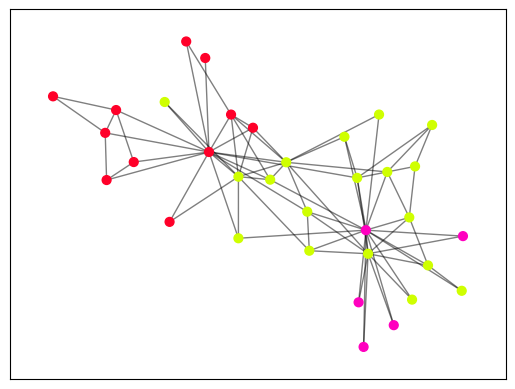

In [230]:
clust=part(G)
cmap = cm.get_cmap('gist_rainbow', int(np.max(clust)+1))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=40, cmap=cmap, node_color=clust)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## Averaging partitions

We would like to calculate an "average". 

### Version 1

Here is one version which compares entire partitions. $n$ is the number of partitions to compare. Expected calculation time: about $n \cdot 0.5 \text{s}$. At the end, the partition which happend most and its likelihood are printed.

In [235]:
n=100
G=nx.karate_club_graph()
res=np.array([[part(G),1]])
for i in range(n-1):
    p=part(G)
    for k in range(len(res[:,0])):
        b=0
        if (res[k,0]==p).all():
            res[k,1]=res[k,1]+1
            b=1
    if b==0:
        res=np.vstack([res,[p,1]])
print(np.max(res[:,1]))
print(res[np.argmax(res[:,1]),0])

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3738160808.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[part(G),1]])


15
0


### Version 2

Now we compare families of vertices among different partitions. In other words, we check if there are communities that are formed in several partitions (and these partitions differ somewhere else). Expected duration about $n\cdot 0.4 \text{s}$.

In [251]:
n=100
G=nx.karate_club_graph()
p=part(G)
if len(np.nonzero(p==1)[0])!=0:
    res=np.array([[np.nonzero(p==1)[0],1]])
for k in range(1,int(np.max(p))):
    if len(np.nonzero(p==k+1)[0])!=0:
        res=np.vstack([res,[np.nonzero(p==k+1)[0],1]])
for i in range(n-1):
    p=part(G)
    for l in range(int(np.max(p))):
        v=np.nonzero(p==l+1)[0]
        if len(v)!=0:
            for k in range(len(res[:,0])):
                b=0
                if len(res[k,0])==len(v) and (res[k,0]==v).all():
                    res[k,1]=res[k,1]+1
                    b=1
            if b==0:
                res=np.vstack([res,[v,1]])
print(np.max(res[:,1]))
print(res[np.argmax(res[:,1]),:])

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/2872942502.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[np.nonzero(p==1)[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


27
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
 27]


In both versions we observe that the "all is one" partition dominates (for spread 3).